# Part 1: Text-Based Sentiment Analysis

## Multimodal Sentiment Analysis Project

### Advanced Predictive Analytics

___

In this project, we build a multimodal sentiment analysis system capable of classifying textual data into different sentiment (positive/negative) and emotion (e.g., joy, sadness, anger) categories. Our approach leverages deep learning models developed in TensorFlow and Keras, with supporting tools for preprocessing, evaluation, and data visualization.

The goal is to:

- Clean and preprocess the raw data (e.g., tokenization, padding, vectorization)

- Train neural networks for sentiment and emotion classification

- Evaluate performance using metrics like accuracy, F1-score, ROC AUC, and precision-recall curves



## Sentiment Data

#### 1. Data Preperation

1.1. Importing libraries

We begin by importing all necessary libraries for deep learning, data manipulation, and evaluation.

In [ ]:
!rm -rf /content/*

In [ ]:
# Deep Learning (TensorFlow & Keras)
import tensorflow as tf  # for building and training deep learning models
from tensorflow import keras  # for high-level model API

from tensorflow.keras import layers, models, Input  # for defining neural network components and model input
from tensorflow.keras.preprocessing.text import Tokenizer  # for converting text to sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences  # for padding sequences
from tensorflow.keras.layers import TextVectorization, Embedding, Layer  # for text input and custom layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # for controlling training process
from tensorflow.keras.models import load_model  # for loading saved models
from tensorflow.keras import regularizers  # for applying L1/L2 regularization
from tensorflow.keras.initializers import Constant  # for setting constant initial weights


#  Machine Learning Utilities (scikit-learn)
from sklearn.model_selection import train_test_split  # for splitting data into training/testing sets
from sklearn.utils.class_weight import compute_class_weight  # for handling class imbalance
from sklearn.preprocessing import MultiLabelBinarizer  # for encoding multilabel classification targets

from sklearn.metrics import confusion_matrix, classification_report  # for model evaluation
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve  # for additional performance metrics


# Data Handling & Analysis
import pandas as pd  # for working with structured data
import numpy as np  # for numerical computations
import collections  # for efficient data structures
from collections import Counter  # for counting item frequencies
import pickle  # for saving/loading Python objects (e.g., tokenizers, label encoders)


# Visualization
import matplotlib.pyplot as plt # for plotting training curves, metrics, etc.


# Text Cleaning & File Management
import os # for interacting with the file system
import re # for text preprocessing with regular expressions


1.2 Reading the data

In this section, we download and extract the IMDb Large Movie Review Dataset (aclImdb), a widely used benchmark for sentiment classification. The dataset contains 50,000 movie reviews split into positive, negative.

In [ ]:
# Downloading the dataset from Stanford's official website
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2025-05-23 12:03:15--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  9.44MB/s    in 15s     

2025-05-23 12:03:30 (5.40 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
# Extracting the compressed .tar.gz file to access the review texts organized by folder
!tar -xvzf aclImdb_v1.tar.gz

A saída de streaming foi truncada nas últimas 5000 linhas.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train

In [ ]:
train_dir = "/content/aclImdb/train"
test_dir = "/content/aclImdb/test"

Now that the IMDb dataset has been extracted, we proceed to load the labeled reviews (positive and negative) from the train and test folders.

In [ ]:
# Set parameters for data loading
batch_size = 32 # number of samples per batch
seed = 42 # random seed for reproducibility

# Load the training dataset (80% of the labeled training data)
train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2, # reserve 20% for validation
    subset='training', # this is the training subset
    seed=seed,
    label_mode='int',
    class_names=['neg', 'pos']  # restrict to these two classes, ignore 'unsup'
)

# Load the validation dataset (20% of the labeled training data)
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2, # use the same split ratio
    subset='validation', # this is the validation subset
    seed=seed,
    label_mode='int',
    class_names=['neg', 'pos'] # again, exclude unsupervised data
)

# Load the test dataset (completely separate from training/validation)
test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    label_mode='int',
    class_names=['neg', 'pos']  # same here for consistency
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


This setup ensures our model is trained and evaluated only on clearly labeled samples.

1.3 Clean the data

Before applying any preprocessing steps, it’s important to explore the structure and contents of the raw text. This helps identify what kind of cleaning may be necessary — such as removing HTML tags, special characters, or excess whitespace.

Below, we inspect one batch from the training set to get a sense of the raw review text and corresponding labels:

In [ ]:
# Take the first batch of examples from the training dataset
for text_batch, label_batch in train_ds.take(1):
    # Iterate through the samples in the batch
    for i in range(len(text_batch)):
        # Print the label and raw text for each example
        print(f"Label: {label_batch[i].numpy()}, Text: {text_batch[i].numpy()}\n")

Label: 0, Text: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'

Label: 0, Text: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as the

As we can see, there are HTML tags and extra whitespace that should be removed to ensure the data is clean and the model performs well. We'll now take care of that.

In [ ]:
# Define a cleaning function to preprocess the text
def tf_clean_text(text, label):
    text = tf.strings.regex_replace(text, '<br />', ' ') # Replace HTML line breaks with a space
    text = tf.strings.regex_replace(text, '\s+', ' ') # Replace multiple spaces or tabs with a single space
    text = tf.strings.strip(text) # Remove leading and trailing whitespace
    return text, label

# Apply the cleaning function to each dataset
train_ds = train_ds.map(tf_clean_text)
val_ds = val_ds.map(tf_clean_text)
test_ds = test_ds.map(tf_clean_text)

The issue should now be resolved, but let's verify by checking the same batch from the training set again.

In [ ]:
# Take one batch from the training dataset
for text_batch, label_batch in train_ds.take(1):
    for i in range(len(text_batch)):
        print(f"Label: {label_batch[i].numpy()}, Text: {text_batch[i].numpy()}\n")

Label: 1, Text: b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up."

Label: 1, Text: b'Caution: May contain spoilers... I\'ve seen this movie 3 times & I\'ve liked it every time. Upon seeing it again, I\'m always reminded of how good it is. An HBO TV movie- very well done like most of their movies are- this would\'ve gotten Oscars for it\'s performances had it been released for general distribution instead of made for TV. 

1.4 Preprocess the Data

Let's determine the optimal number of most frequent words and the ideal sequence length, so we can properly set the values for the max_tokens and sequence_length parameters during tokenization.

**Best Vocabulary Size**

In [ ]:
# Collect all texts from the training dataset into a list
train_texts = []

for batch in train_ds:
    texts, labels = batch
    for text in texts:
        # Convert each text tensor to a UTF-8 decoded string and add to the list
        train_texts.append(text.numpy().decode('utf-8'))

# Initialize a Counter to count word frequencies across all texts
word_counts = Counter()

# For each review, split the text into words and update the frequency counter
for text in train_texts:
    word_counts.update(text.split())

# Total number of unique words in the dataset
print(f"Total unique words: {len(word_counts)}")

# 10 most common words and their frequencies
print(f"Top 10 words: {word_counts.most_common(10)}")

Total unique words: 231028
Top 10 words: [('the', 230617), ('a', 124128), ('and', 122703), ('of', 114956), ('to', 105993), ('is', 82695), ('in', 68443), ('I', 55783), ('that', 51732), ('this', 45989)]


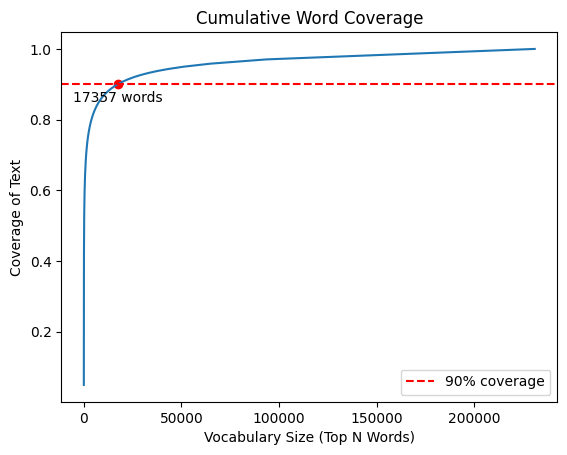

90% of the coverage is achieved with 17357 words.


In [ ]:
# Cumulative coverage plot

# Get word frequencies sorted from most to least common
frequencies = [count for word, count in word_counts.most_common()]

# Compute cumulative sum normalized by total frequency
cumulative = np.cumsum(frequencies) / np.sum(frequencies)

# Plot the cumulative word coverage
plt.plot(cumulative)
plt.xlabel("Vocabulary Size (Top N Words)")
plt.ylabel("Coverage of Text")
plt.axhline(y=0.90, color='r', linestyle='--', label='90% coverage')  # 95% coverage line

# Identify the index where 90% of coverage is first reached
coverage_index = np.argmax(cumulative >= 0.90)
plt.scatter(coverage_index, cumulative[coverage_index], color='red')  # ponto no gráfico
plt.text(coverage_index, cumulative[coverage_index] - 0.05, f'{coverage_index} words', ha='center')

plt.title("Cumulative Word Coverage")
plt.legend()
plt.show()

print(f"90% of the coverage is achieved with {coverage_index} words.")

The plot shows that approximately 90% of the text coverage is achieved with just the top 17,357 words. This indicates that we can safely set the max_tokens parameter to around 20,000, which balances vocabulary richness and model efficiency by covering most of the important terms while excluding infrequent noise.

**Choosing the Best Review Length**

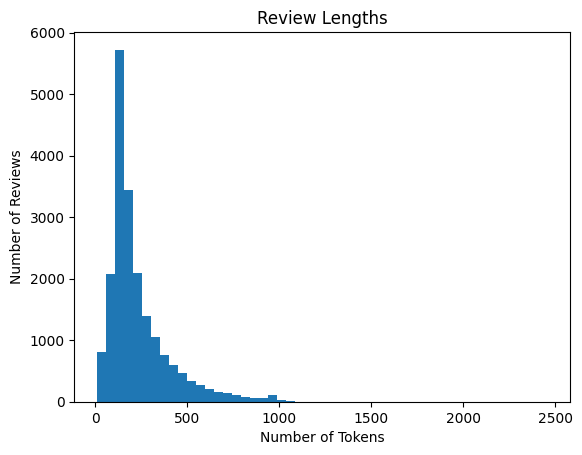

90th percentile length: 453.0
95th percentile length: 590.0499999999993


In [ ]:
# Initialize a list to store the token lengths of each review
lengths = []

# Iterate through the training dataset to compute review lengths
for text_batch, _ in train_ds:
    for text in text_batch:
        lengths.append(len(text.numpy().decode('utf-8').split()))

# Plot a histogram of review lengths (number of tokens per review)
plt.hist(lengths, bins=50)
plt.title('Review Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Reviews')
plt.show()

# Find percentiles
print(f"90th percentile length: {np.percentile(lengths, 90)}")
print(f"95th percentile length: {np.percentile(lengths, 95)}")

Based on the distribution of review lengths, we observe that 90% of reviews contain 453 tokens or fewer. To balance information retention and computational efficiency, we choose 400 tokens as our maximum sequence length. This value is sufficient to capture the majority of the content while keeping the model size manageable.



**Final Decision**

In [ ]:
# Text vectorization setup
max_tokens = 20000
sequence_length = 400

#### 2. Training the Model

2.1 Tokenize and  Word-to-Index

To prepare the data for modeling, we first initialize a Keras Tokenizer. We define a vocabulary limited to the top max_tokens most frequent words, specify a special token for out-of-vocabulary words (<OOV>), and convert all text to lowercase. We also customize the filters to remove unwanted punctuation and special characters during tokenization.

In [ ]:
tokenizer = Tokenizer(
    num_words=max_tokens, # Limit the vocabulary to the top 'max_tokens' most frequent words
    oov_token="<OOV>", # Token to represent out-of-vocabulary words
    lower=True, # Convert all text to lowercase
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' # Characters to remove during tokenization
)

To avoid data leakage, we fit the tokenizer only on the training set. This ensures the model learns vocabulary solely from training data and doesn’t accidentally gain information from validation or test sets. We iterate through the training dataset, decode each review, and pass the list of texts to tokenizer.fit_on_texts().



In [ ]:
# Create a list to store all training review texts
train_texts = []

# Iterate through the training dataset
for text_batch, label_batch in train_ds:
    for text_tensor in text_batch:
        # Decode each text tensor from bytes to string and add to the list
        train_texts.append(text_tensor.numpy().decode("utf-8"))

# Fit the tokenizer on the training texts to build the word index
# This maps each word to a unique integer based on frequency
tokenizer.fit_on_texts(train_texts)


2.2 Preprocess the datasets

After fitting the tokenizer, we convert all text data (training, validation, and test sets) into padded sequences of integers. This transformation is necessary for feeding the input into our LSTM model. We define a function to tokenize, pad, and batch the datasets efficiently, and save the tokenizer for future reuse or inference.

In [ ]:
# Define a function to tokenize, pad, and prepare a dataset
def tokenize_and_pad(ds):
    texts = [] # List to store decoded text
    labels = [] # List to store corresponding labels

    # Loop through the dataset batches
    for text_batch, label_batch in ds:
        for t in text_batch:
            # Decode text from tensor and append to list
            texts.append(t.numpy().decode("utf-8"))
        for l in label_batch:
            # Convert label tensor to integer and store
            labels.append(l.numpy())

    # Convert text to sequences of integers using the fitted tokenizer
    sequences = tokenizer.texts_to_sequences(texts)

    # Pad sequences to uniform length (post-padding/truncating)
    padded = pad_sequences(sequences, maxlen=sequence_length, padding="post", truncating="post")
    return tf.data.Dataset.from_tensor_slices((padded, labels)).batch(256).prefetch(tf.data.AUTOTUNE)

# Apply the preprocessing function to all datasets
train_ds_vec = tokenize_and_pad(train_ds)
val_ds_vec = tokenize_and_pad(val_ds)
test_ds_vec = tokenize_and_pad(test_ds)

In [ ]:
# Save the tokenizer to a file for later use
with open("tokenizer_sentimento.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

##### 2.3  LSTM Model

We begin by applying the **LSTM architecture**. LSTMs are well-suited for text classification because they can capture long-term dependencies and sequential patterns in the data. Their ability to retain information across time steps makes them especially effective for understanding the context of movie reviews and predicting sentiment with greater accuracy.



2.3.1 Embedding Layer

To enhance our model with semantic knowledge, we use pre-trained GloVe word embeddings. GloVe (Global Vectors for Word Representation) captures word meanings based on co-occurrence statistics from large corpora. We download and extract the GloVe vectors to later integrate them into our embedding layer, allowing the model to start with meaningful word representations rather than learning them from scratch.

In [ ]:
# Download the GloVe pre-trained word vectors from Stanford
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2025-05-23 12:17:53--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-23 12:17:54--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 38s  

2025-05-23 12:20:33 (5.19 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
# Unzip the downloaded file to access embedding text files
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


We now have to create an embedding matrix that maps our tokenizer’s word indices to the corresponding GloVe vectors. This matrix will be used to initialize the weights of the Embedding layer, enabling the model to start with rich, semantic word representations.



In [ ]:
# Path to the GloVe file (make sure the file exists in this location)
path_to_glove_file = "glove.6B.100d.txt"

# Dictionary to store word:vector pairs from GloVe
embeddings_index = {}

# Read and parse each line in the GloVe file
with open(path_to_glove_file, encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1) # split word from vector
        coefs = np.fromstring(coefs, dtype="float32", sep=" ") # convert string to numpy array
        embeddings_index[word] = coefs # store in dictionary

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [ ]:
embedding_dim = 100  # Must match the selected GloVe dimension
word_index = tokenizer.word_index # Get word index from tokenizer

# Initialize embedding matrix with zeros: shape = (vocab size, embedding dim)
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill the matrix with GloVe vectors for words in our vocabulary
for word, idx in word_index.items():
    if idx < max_tokens:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (20000, 100)


The embedding matrix has a shape of (20,000, 100) because we limited our tokenizer vocabulary to the top 20,000 most frequent words (max_tokens), and we are using 100-dimensional GloVe vectors (embedding_dim = 100)

In [ ]:
embedding_layer = Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,

    # Initialize the layer with our pre-trained GloVe embedding matrix
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),

    trainable=False # Keep embeddings fixed (not updated during training)
)

2.3.2 Architecture

We define our model using a Sequential architecture, which allows us to stack layers in a linear flow from input to output.

- 1. Embedding Layer
The model begins with a pre-trained GloVe embedding layer. This helps the model generalize better, especially with smaller datasets.

- 2. Bidirectional LSTM Layer
Next, we use a Bidirectional LSTM with 64 units. LSTMs are good for sequential data, as they retain memory across time steps. Using bidirectional LSTM enhances this by considering both past (left context) and future (right context) information in a sentence — crucial for understanding the sentiment of a review.

- 3. Dropout Layer
After the LSTM, we apply another Dropout(0.3), which regularizes the output of the LSTM and reduces the chance of overfitting by randomly dropping 30% of units.

- 4. Dense Layer (64 units, ReLU)
A fully connected layer with 64 units and ReLU activation. It helps the model learn non-linear combinations of features extracted by the LSTM. 64 is a balanced size: large enough to capture patterns, small enough to avoid overfitting.

- 5. Second Dropout Layer
Again, a Dropout(0.3) is applied to the dense layer output to further prevent overfitting.

- 6. Output Layer
A Dense(1) (single neuron) with a sigmoid activation. This outputs a probability between 0 and 1, ideal for binary classification (positive/negative)

In [ ]:
# Define the LSTM model architecture
lstm_model = models.Sequential([
    embedding_layer, # Pre-trained GloVe embedding (non-trainable)
    layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)), # Bidirectional LSTM to capture both past and future context
    layers.Dropout(0.3), # Regularization to prevent overfitting

    layers.Dense(64, activation='relu'), # Fully connected layer with ReLU
    layers.Dropout(0.3), # Additional dropout for regularization
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model with binary crossentropy loss and accuracy metric
lstm_model.compile(
    loss='binary_crossentropy',  # binary 0/1
    optimizer=optimizer,
    metrics=['accuracy']
)

# Display summary (won’t show output shapes until input shape is defined)
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_model.build(input_shape=(None, sequence_length))
lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 400, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,092,801 (7.98 MB)

 Trainable params: 92,801 (362.50 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

- Embedding Layer: (None, 400, 100) — 400 tokens per review, 100-dimensional vectors.

- Bidirectional LSTM: Outputs a 128-dimensional vector (64 units forward + 64 backward).

- Dense + Dropout: Refines features and improves generalization.

- Final Dense: Outputs a single probability for binary sentiment classification.



We train the LSTM model using the prepared and vectorized datasets over 10 epochs. To improve training efficiency and avoid overfitting, we use two callbacks:

- EarlyStopping: Monitors validation accuracy (val_accuracy) and stops training if no improvement is observed for 2 consecutive epochs (patience=2). We also restore the best weights.

- ModelCheckpoint: Saves the model weights to a file (best_model.h5) whenever a new best validation accuracy is reached.

These callbacks help ensure the model doesn't overtrain and that we retain the best-performing version for evaluation.

In [ ]:
callbacks = [
    # Stop training early if validation accuracy doesn't improve for 2 consecutive epochs
    EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True),

    # Save the model only when it achieves a new best validation accuracy
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
]

In [ ]:
history_lstm = lstm_model.fit(
    train_ds_vec,
    validation_data=val_ds_vec,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5346 - loss: 0.6894

79/79 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.5350 - loss: 0.6893 - val_accuracy: 0.6602 - val_loss: 0.6322
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6397 - loss: 0.6415

79/79 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.6399 - loss: 0.6414 - val_accuracy: 0.7424 - val_loss: 0.5443
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6900 - loss: 0.6002

79/79 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.6902 - loss: 0.6000 - val_accuracy: 0.7712 - val_loss: 0.4966
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7227 - loss: 0.5647

79/79 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.7229 - loss: 0.5646 - val_accuracy: 0.7884 - val_loss: 0.4750
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7538 - loss: 0.5268

79/79 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.7538 - loss: 0.5267 - val_accuracy: 0.8016 - val_loss: 0.4549
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7709 - loss: 0.4988

79/79 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.7710 - loss: 0.4986 - val_accuracy: 0.8114 - val_loss: 0.4195
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7914 - loss: 0.4657

79/79 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.7914 - loss: 0.4657 - val_accuracy: 0.8198 - val_loss: 0.3993
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8023 - loss: 0.4469

79/79 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8023 - loss: 0.4468 - val_accuracy: 0.8250 - val_loss: 0.3855
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8047 - loss: 0.4358

79/79 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8047 - loss: 0.4357 - val_accuracy: 0.8270 - val_loss: 0.3833
Epoch 10/10
18/79 ━━━━━━━━━━━━━━━━━━━━ 1:17 1s/step - accuracy: 0.8148 - loss: 0.4258

In [ ]:
best_model = load_model('best_model.h5')

2.1.4  Performance Metrics

Since the dataset is approximately balanced between positive and negative reviews, we use accuracy as our main evaluation metric. After training, we will noe evaluate the model on the test set and visualize the learning curves for both accuracy and loss on the training and validation sets.

In [ ]:
# Evaluate the best saved model on the test dataset
loss, accuracy = best_model.evaluate(test_ds_vec)

# Print the test accuracy with 4 decimal places
print(f"Test Accuracy: {accuracy:.4f}")

98/98 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.8398 - loss: 0.3697
Test Accuracy: 0.8416


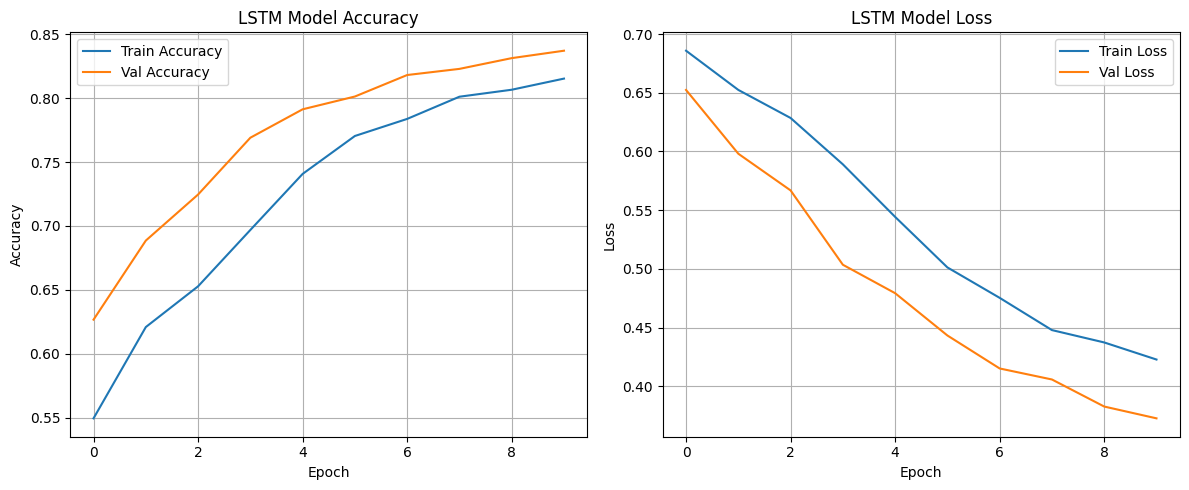

In [ ]:
# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# First subplot - Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Model Accuracy')
plt.legend()
plt.grid(True)

# Second subplot - Loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Model Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

These plots help us assess model performance and detect signs of underfitting or overfitting. From the plots:

- Accuracy: Both training and validation accuracy improve steadily, with validation accuracy consistently higher — suggesting good generalization.

- Loss: Training and validation loss decrease consistently, showing the model is learning effectively and not overfitting.

Overall, the curves indicate a healthy training process with no signs of underfitting or overfitting. The use of dropout and early stopping likely contributed to this stable performance.

In [ ]:
true_labels = []  # List to store actual labels
pred_labels = []  # List to store predicted labels

# Generate predictions on the test dataset
for x_batch, y_batch in test_ds_vec:
    y_pred = best_model.predict(x_batch)# Model outputs probabilities

    true_labels.extend(y_batch.numpy())  # Ground truth labels (already 0 or 1)

    # Convert probabilities to binary predictions (threshold = 0.5)
    pred_labels.extend((y_pred >= 0.5).astype(int).reshape(-1))

# Evaluate the model using confusion matrix and classification report
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:\n", cm)

# Print precision, recall, f1-score for each class (negative and positive)
print(classification_report(true_labels, pred_labels, target_names=['neg', 'pos']))

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 315ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 

The classification report shows balanced performance across both classes:

- Negative class (neg): Precision = 0.86, Recall = 0.81

- Positive class (pos): Precision = 0.82, Recall = 0.87

- F1-scores are nearly identical: 0.84 for neg, 0.85 for pos, indicating a good trade-off between precision and recall.

Overall accuracy is 84%, and both macro and weighted averages confirm balanced performance, making this model reliable for a dataset with equal class distribution.

##### 2.4 CNN Model

As an alternative to LSTM, we also experiment with a Convolutional Neural Network (CNN) for text classification. CNNs are effective in capturing local patterns in sequences, such as key n-grams or short phrases that strongly signal sentiment. By applying convolutional filters over the word embeddings, the model can detect important spatial patterns in the text. These features are then passed through max-pooling layers and fully connected layers for classification. CNNs are typically faster to train than LSTMs and can perform well when the global sequence order is less important than the presence of specific phrases.

2.4.1 Architecture

We define our CNN model using a Sequential architecture, which processes the input step-by-step through a linear stack of layers.

- 1. Embedding Layer
As with the LSTM model, we start with a pre-trained GloVe embedding layer. This provides a strong starting point and helps prevent overfitting.

- 2. First Convolutional Layer
We apply a Conv1D layer. This layer helps the model learn local textual features like phrases or expressions associated with sentiment.

- 3. MaxPooling Layer
Next, we apply a MaxPooling1D, which keeps only the most important features within each window preventing the model from focusing too much on local noise.

- 4. Second Convolutional Layer
A second Conv1D layer is added

- 5. Global Average Pooling Layer
We apply a GlobalAveragePooling1D layer instead of flattening or max pooling, since is less aggressive than GlobalMaxPooling, making it more robust for generalization.

- 6. Dropout Layer
A Dropout layer follows, preventing co-adaptation and reducing overfitting.

- 7. Dense Layer (32 units, ReLU)
This layer helps transform extracted features into a higher-level representation.

- 8. Second Dropout Layer
We apply another Dropout.

- 9. Output Layer
The final layer is a Dense with a sigmoid activation function

In [ ]:
# Define the CNN model architecture
cnn_model = models.Sequential([
    embedding_layer,
    layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling1D(2),  # Downsample gradually
    layers.Conv1D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.GlobalAveragePooling1D(),  # Gentler than GlobalMaxPooling
    layers.Dropout(0.3),  # Reduce dropout
    layers.Dense(32, activation='relu'),  # Smaller dense layer
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Define the optimizer with a lower learning rate for stable convergence
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model with binary crossentropy loss and accuracy metric
cnn_model.compile(
    loss='binary_crossentropy',  # perfect for two classes (0 or 1)
    optimizer=optimizer,
    metrics=['accuracy']
)

# Print a summary of the model architecture
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 400, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

In [ ]:
cnn_model.build(input_shape=(None, sequence_length))
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 400, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 400, 64)        │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 200, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,079,589 (7.93 MB)

 Trainable params: 26,529 (103.63 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

 Optimizer params: 53,060 (207.27 KB)

- Embedding Layer: This layer transforms each of the 400 tokens in a sequence into a 100-dimensional vector.

- First Conv1D Layer: Applies 64 filters with kernel size 3.

- MaxPooling1D: Reduces sequence length by half, keeping only the most important local features.

- Second Conv1D Layer: Uses 32 filters to extract deeper features.

- GlobalAveragePooling1D: Averages features across the entire sequence dimension, resulting in a fixed-size vector. More stable and less aggressive than max pooling.

- Dense Layers & Dropout: A Dense layer introduces non-linearity, followed by Dropout to prevent overfitting.

- The final Dense(1) neuron with sigmoid activation outputs the binary sentiment prediction.

We now prepare to train our CNN model using the vectorized datasets. To ensure efficient training and avoid overfitting, we use the same strategy as with the LSTM: early stopping and model checkpointing.

In [ ]:
callbacks = [
    # Stop training early if validation accuracy doesn't improve for 5 epochs
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),

    # Save the model whenever it achieves a new best validation accuracy
    ModelCheckpoint('best_model_cnn.h5', monitor='val_accuracy', save_best_only=True, mode='max')
]

# Train the CNN model
history_cnn = cnn_model.fit(
    train_ds_vec,
    validation_data=val_ds_vec,
    epochs=10,
    callbacks = callbacks
)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.4939 - loss: 1.8492

79/79 ━━━━━━━━━━━━━━━━━━━━ 43s 504ms/step - accuracy: 0.4940 - loss: 1.8485 - val_accuracy: 0.5444 - val_loss: 1.6896
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.4991 - loss: 1.6480

79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 460ms/step - accuracy: 0.4992 - loss: 1.6475 - val_accuracy: 0.5570 - val_loss: 1.5180
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.5154 - loss: 1.4823

79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 482ms/step - accuracy: 0.5154 - loss: 1.4818 - val_accuracy: 0.5734 - val_loss: 1.3738
Epoch 4/10
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.5297 - loss: 1.3436

79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 474ms/step - accuracy: 0.5297 - loss: 1.3429 - val_accuracy: 0.5954 - val_loss: 1.2528
Epoch 5/10
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.5314 - loss: 1.2287

79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 483ms/step - accuracy: 0.5316 - loss: 1.2280 - val_accuracy: 0.6118 - val_loss: 1.1515
Epoch 6/10
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.5440 - loss: 1.1325

79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 475ms/step - accuracy: 0.5443 - loss: 1.1320 - val_accuracy: 0.6210 - val_loss: 1.0670
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.5612 - loss: 1.0504

79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 471ms/step - accuracy: 0.5613 - loss: 1.0502 - val_accuracy: 0.6224 - val_loss: 0.9965
Epoch 8/10
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.5767 - loss: 0.9837

79/79 ━━━━━━━━━━━━━━━━━━━━ 43s 496ms/step - accuracy: 0.5769 - loss: 0.9834 - val_accuracy: 0.6260 - val_loss: 0.9370
Epoch 9/10
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.5913 - loss: 0.9268

79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 467ms/step - accuracy: 0.5913 - loss: 0.9265 - val_accuracy: 0.6548 - val_loss: 0.8865
Epoch 10/10
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.6131 - loss: 0.8804

79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 497ms/step - accuracy: 0.6132 - loss: 0.8802 - val_accuracy: 0.6718 - val_loss: 0.8430


In [ ]:
best_model_cnn = load_model('best_model_cnn.h5')

2.4.2 Performance Metrics

To evaluate our CNN model, we use binary cross-entropy loss and accuracy as performance metrics. Accuracy is appropriate because the dataset is balanced, and binary cross-entropy is the standard loss function for binary classification tasks. These metrics allow us to track how well the model is learning and generalizing during training and validation.

In [ ]:
loss, accuracy = best_model_cnn.evaluate(test_ds_vec)
print(f"Test Accuracy: {accuracy:.4f}")

98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.6678 - loss: 0.8444
Test Accuracy: 0.6659


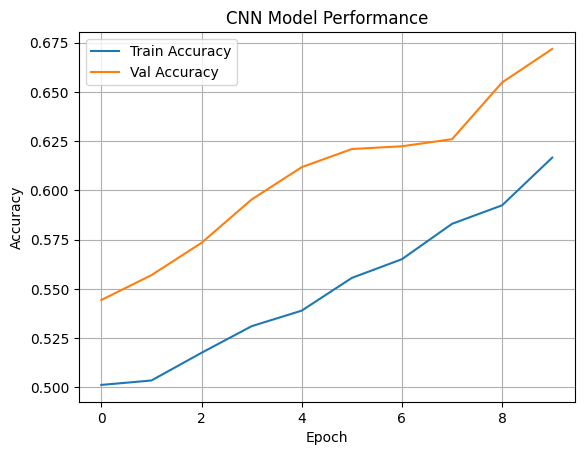

In [ ]:
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Model Performance')
plt.legend()
plt.grid(True)
plt.show()

The CNN model achieved a test accuracy of 66.6%, which is significantly lower than the LSTM’s performance. Although the training and validation curves do not indicate overfitting—with validation accuracy even slightly higher than training accuracy—the model struggles to generalize to unseen data. This suggests that while CNNs can capture local patterns effectively, they may not be as suitable as LSTMs for understanding the broader sequential context needed in sentiment classification of full movie reviews.

In [ ]:
# Take one batch from the test dataset
for x_batch, y_batch in test_ds_vec.take(1):

    # Predict probabilities for the batch using the trained CNN model
    predictions = cnn_model.predict(x_batch)

    # Convert probabilities to binary labels (1 if >= 0.5, else 0)
    predicted_labels = (predictions >= 0.5).astype(int)

    print("Original texts:", x_batch.numpy()[:5])
    print("True labels:  ", y_batch.numpy()[:5])
    print("Predictions:  ", predicted_labels[:5].reshape(-1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Original texts: [[   11   384    44 ...     0     0     0]
 [15286   150   105 ...     0     0     0]
 [13280   314    58 ...     0     0     0]
 [ 7301   655    10 ...     0     0     0]
 [   42    40   521 ...     0     0     0]]
True labels:   [0 0 0 0 1]
Predictions:   [0 1 0 0 0]


In [ ]:
# Collect all true labels and predictions
true_labels = []
pred_labels = []

for x_batch, y_batch in test_ds_vec:
    y_pred = cnn_model.predict(x_batch)
    true_labels.extend(y_batch.numpy())
    pred_labels.extend((y_pred >= 0.5).astype(int).reshape(-1))

# Print confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:\n", cm)

# Print classification report
print(classification_report(true_labels, pred_labels, target_names=['neg', 'pos']))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
8/8 ━━━━━━━━

The confusion matrix and classification report show that the CNN model achieves a test accuracy of 67%. It performs slightly better on the negative class (precision: 0.64, recall: 0.77) than on the positive class (precision: 0.71, recall: 0.56), suggesting it is more confident when predicting negative sentiment but struggles to correctly identify all positive reviews. Overall, the macro and weighted averages remain consistent at around 0.66–0.67, confirming balanced—but moderate—performance across classes.

Compared to the LSTM model, which achieved an accuracy of 84% and F1-scores around 0.84–0.85 for both classes, the CNN model underperforms significantly. While CNNs are effective at capturing local features, they may lack the ability to model long-range dependencies and overall context as effectively as LSTMs — a key factor in tasks like sentiment analysis, where understanding the full review is critical.


## Emotions Data

#### 1. Data Preperation

1.1 Reading the data

We now download the GoEmotions dataset. The dataset is split across three CSV files (goemotions_1.csv, goemotions_2.csv, and goemotions_3.csv). These files contain labeled data that will later be used for multi-label emotion classification.

In [ ]:
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

--2025-05-22 11:23:04--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.207, 108.177.11.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/full_dataset/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  37.3MB/s    in 0.4s    

2025-05-22 11:23:05 (37.3 MB/s) - ‘data/full_dataset/goemotions_1.csv’ saved [14174600/14174600]

--2025-05-22 11:23:05--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.207, 108.177.11.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.207|:443... connected.
HTTP request sent, awaiting respons

We now move on to aggregating the three downloaded CSV files into a single dataset. During this process, we exclude any rows labeled as example_very_unclear, as these represent unlabeled or ambiguous entries that are not useful for training or evaluation. This ensures that the final dataset only includes clearly annotated examples suitable for emotion classification.

In [ ]:
df1 = pd.read_csv("data/full_dataset/goemotions_1.csv")
df2 = pd.read_csv("data/full_dataset/goemotions_2.csv")
df3 = pd.read_csv("data/full_dataset/goemotions_3.csv")

emotions_df = pd.concat([df1, df2, df3], ignore_index=True)

emotions_df = emotions_df[~emotions_df['example_very_unclear']]

And do a little inspection to see what to expect

In [ ]:
# Display column names and sample rows
print(emotions_df.columns)
print(emotions_df.head())

# Check label distribution (assuming columns are emotion labels)
print(emotions_df.iloc[:, 2:].sum())  # Columns 2+ are emotions (27 classes + neutral)

Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
       'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')
                                                text       id  \
0                                    That game hurt.  eew5j0j   
2     You do right, if you don't care then fuck 'em!  ed2mah1   
3                                 Man I love reddit.  eeibobj   
4  [NAME] was nowhere near them, he was by the Fa...  eda6yn6   
5  Right? Considering it’s such an important docu...  eespn2i   

                author            subreddit    link_id   parent_id  \
0                Brdd9

From a quick inspection of the dataset, we can observe a few key points:

- There are several columns that appear irrelevant for our use case and can likely be dropped.

- The text contains Reddit-specific tags and formatting (e.g., markdown, user mentions) that should be cleaned or removed during preprocessing to ensure better model performance.

1.2 Clean the data

Before designing any models, we begin with the most important step: cleaning the data. High-quality preprocessing is essential to ensure the model learns from meaningful and consistent input.

In [ ]:
def clean_text(text):
    text = str(text).lower()  # Lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

emotions_df["text"] = emotions_df["text"].apply(clean_text)

We now divide the dataset into components that will be useful for training:

- Emotion columns: the columns that represent individual emotion labels

- y: the values from these emotion columns, representing the multi-label targets

- x: the corresponding text input (Reddit comments) that we want to classify

This separation allows us to clearly define our features and labels before proceeding with preprocessing and modeling.

In [ ]:
# Define emotion columns (from the dataset)
emotion_cols = emotions_df.columns[emotions_df.columns.get_loc("admiration"):]

# Extract labels (assuming one-hot encoded columns)
y = emotions_df[emotion_cols].values  # Shape: (n_samples, 28)

# Extract cleaned text
X = emotions_df["text"].values

In [ ]:
emotions_df.columns[emotions_df.columns.get_loc("admiration"):]

Index(['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')

To assess the balance of the dataset, we plotted the distribution of emotions across the dataset. This helps us identify whether certain emotions are overrepresented or underrepresented, which is important for choosing the right evaluation metrics and potentially applying class balancing techniques.

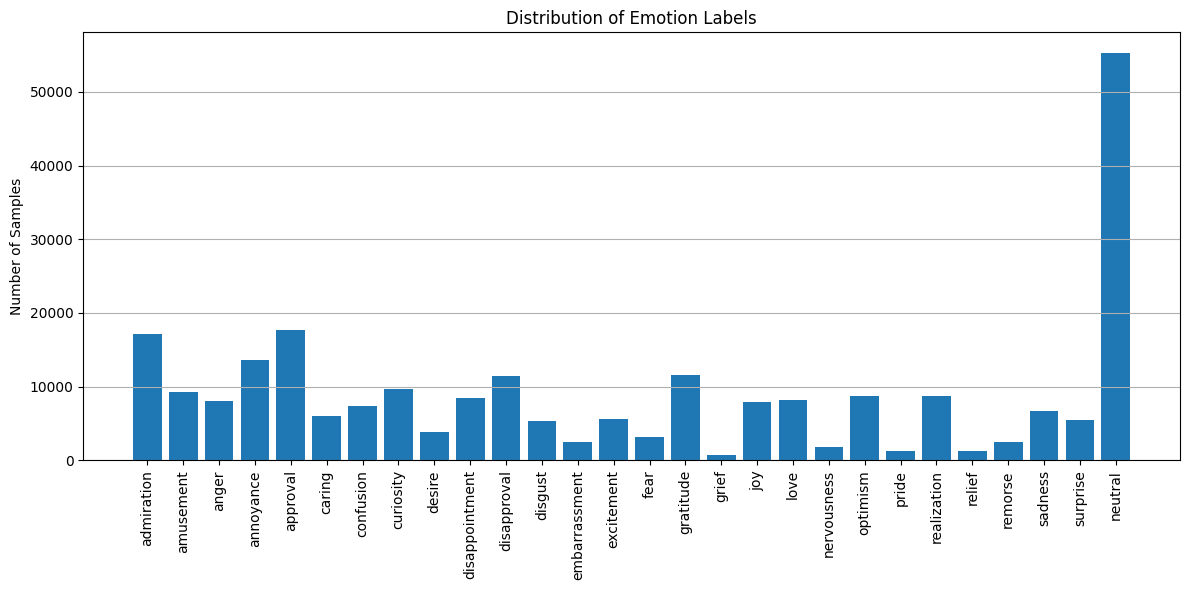

In [ ]:
# Sum each column (count of each emotion)
emotion_counts = y.sum(axis=0)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(emotion_cols, emotion_counts)
plt.xticks(rotation=90)
plt.title("Distribution of Emotion Labels")
plt.ylabel("Number of Samples")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

The dataset shows a strong class imbalance, particularly for the "neutral" emotion, which appears much more frequently than others. To prevent the model from being biased toward this overrepresented class, we decided to undersample the "neutral-only" examples. Specifically, we keep only a subset of comments that are labeled exclusively as "neutral", bringing their count closer to the average frequency of the other emotions. This helps rebalance the dataset while preserving a diverse set of multi-label examples.



In [ ]:
# Count how many times each emotion appears across the dataset
label_counts = pd.DataFrame(y, columns=emotion_cols).sum().sort_values(ascending=False)

# Remove 'neutral' from the count for the purpose of calculating the average
label_counts.drop("neutral", inplace=True)

# Calculate how many neutral-only samples to keep (based on mean of other emotions)
n_neutral_to_keep = int(label_counts.mean())

In [ ]:
# Combine the text (X) and labels (y) into a single DataFrame
full_df = pd.DataFrame(X, columns=["text"])
labels_df = pd.DataFrame(y, columns=emotion_cols)
full_df = pd.concat([full_df, labels_df], axis=1)

# Create a mask to find rows that are ONLY labeled as 'neutral' (no other emotions)
neutral_only_mask = (full_df[emotion_cols].sum(axis=1) == 1) & (full_df["neutral"] == 1)

# Randomly sample a subset of those neutral-only rows
neutral_sample = full_df[neutral_only_mask].sample(n=n_neutral_to_keep, random_state=42)

# Keep all rows that have any emotion other than just neutral
non_neutral = full_df[~neutral_only_mask]

# Combine the sampled neutral rows with all non-neutral rows
balanced_df = pd.concat([neutral_sample, non_neutral], ignore_index=True).sample(frac=1, random_state=42)

# Extract the final balanced text and labels
X_balanced = balanced_df["text"].values
y_balanced = balanced_df[emotion_cols].values

In [ ]:
X = X_balanced
y = y_balanced

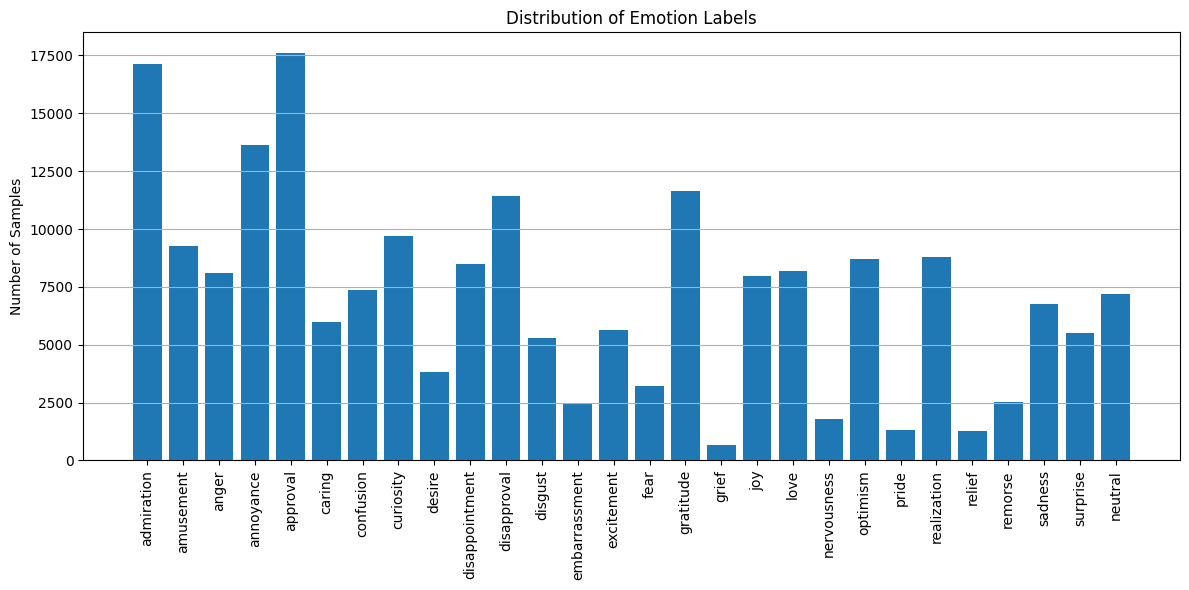

In [ ]:
# Sum each column (count of each emotion)
emotion_counts = y.sum(axis=0)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(emotion_cols, emotion_counts)
plt.xticks(rotation=90)
plt.title("Distribution of Emotion Labels")
plt.ylabel("Number of Samples")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

After this undersampling step, the dataset is now more balanced, especially in reducing the dominance of the "neutral" class. However, there are still noticeable imbalances among the remaining emotions, which is expected in multi-label emotion datasets. These will be taken into account during model evaluation and metric selection.

1.3 Train/Test split

We now split the dataset into training (80%), validation (10%), and test (10%) sets. This ensures that we have enough data to train the model, tune hyperparameters, and evaluate final performance on unseen data. The splits are done using train_test_split with a fixed random seed for reproducibility.



In [ ]:
# Split into train (80%), validation (10%), and test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 127767, Val: 15971, Test: 15971


1.4 Tokenize

To prepare the text for input into a neural network, we tokenize the dataset using Keras' Tokenizer. After tokenization, we pad the sequences to ensure uniform input size, then wrap everything in TensorFlow Dataset objects for efficient batching and training.



In [ ]:
# Initialize the tokenizer (initially without vocab size restriction)
tokenizer = Tokenizer(
    oov_token="<OOV>",
    lower=True,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
)

# Fit the tokenizer on the training text to build the word index
tokenizer.fit_on_texts(X_train)

# Calculate the total vocabulary size after fitting (+1 for OOV token)
vocab_size = len(tokenizer.word_index) + 1  # +1 for OOV token
print(f"Vocabulary size: {vocab_size}")

# Reinitialize tokenizer with vocab_size if needed
tokenizer = Tokenizer(
    num_words=vocab_size,
    oov_token="<OOV>",
    lower=True,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
)

tokenizer.fit_on_texts(X_train)

# Now proceed with tokenization
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

Vocabulary size: 31251


In [ ]:
#Cap at a reasonable limit (e.g., 95th percentile)
lengths = [len(seq) for seq in X_train_seq]
max_length = int(np.percentile(lengths, 95))
print(f"95th percentile length: {max_length}")

95th percentile length: 24


In [ ]:
# Tokenize & Pad
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding="post", truncating="post")
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding="post", truncating="post")

In [ ]:
# Create TensorFlow datasets with shuffling, batching, and prefetching
train_ds = tf.data.Dataset.from_tensor_slices((X_train_pad, y_train))
train_ds = train_ds.shuffle(1000, seed=42, reshuffle_each_iteration=False).batch(256).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val_pad, y_val))
val_ds = val_ds.batch(256).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Save the tokenizer
with open("tokenizer_emocoes.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save max lenght
with open("maxlen_emocoes.pkl", "wb") as f:
    pickle.dump(max_length, f)

#### 2. Training the Model

##### 2.1 LSTM Architecture

As before, we will now test an LSTM-based architecture, as it is well-suited for text classification tasks. LSTMs are effective at capturing the sequential structure and long-term dependencies within text, which is especially valuable in multi-label emotion classification where context plays a critical role.

2.1.1 Embedding Layer

We apply the same steps as before with the new parameters

In [ ]:
# Load GloVe vectors
embedding_dim = 100
embeddings_index = {}

with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        embeddings_index[word] = np.fromstring(coefs, sep=" ", dtype=np.float32)

print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")

# Build the embedding matrix for your tokenizer
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print(f"Embedding matrix shape: {embedding_matrix.shape}")



Loaded 400000 word vectors from GloVe.
Embedding matrix shape: (31251, 100)


In [ ]:
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=max_length,
    trainable=False
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2.1.2 Custom Components

Further on we will apply:
- A custom attention layer to help the LSTM model focus on important parts of the sequence.

- A focal loss function to handle class imbalance by focusing more on difficult examples.

- Class weights computed per label to further address imbalance during training.



In [ ]:
# Custom Attention Layer to highlight important time steps in the input sequence
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.nn.tanh(tf.matmul(x, self.W) + self.b)  # shape: (batch_size, seq_len, 1)
        at = tf.nn.softmax(et, axis=1)  # shape: (batch_size, seq_len, 1)
        output = x * at  # Apply attention weights (broadcasted multiplication)
        return output  # shape: (batch_size, seq_len, features)

In [ ]:
# Define Focal Loss function to address class imbalance
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)

        return tf.reduce_mean(alpha_factor * modulating_factor * cross_entropy)
    return loss

In [ ]:
class_weights = []
for i in range(y_train.shape[1]):
    classes = np.unique(y_train[:, i])
    if len(classes) == 1:
        # Handle single-class columns (assign neutral weight 1.0)
        weight = 1.0
    else:
        # Compute class weight using sklearn's balanced mode
        weights = compute_class_weight('balanced', classes=classes, y=y_train[:, i])

        # Use the weight for class 1 (presence of the emotion); fallback to 1.0 if needed
        weight = weights[1] if len(weights) > 1 else 1.0

    class_weights.append(weight)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(4.67052931715163), 1: np.float64(8.635239253852392), 2: np.float64(9.980237462896422), 3: np.float64(5.8330441928414904), 4: np.float64(4.537824975138514), 5: np.float64(13.297980849292257), 6: np.float64(10.794778641432917), 7: np.float64(8.297636056630731), 8: np.float64(20.89061478090255), 9: np.float64(9.540546594982079), 10: np.float64(6.972658808120498), 11: np.float64(14.971525662057651), 12: np.float64(31.798656047784966), 13: np.float64(14.15230394328755), 14: np.float64(25.240418806795734), 15: np.float64(6.850777479892761), 16: np.float64(114.28175313059035), 17: np.float64(9.955352968676952), 18: np.float64(9.789074471345387), 19: np.float64(42.99024226110363), 20: np.float64(9.143194504079004), 21: np.float64(62.32536585365854), 22: np.float64(9.04993625159371), 23: np.float64(61.24976030680729), 24: np.float64(31.485214391325776), 25: np.float64(11.845633228258855), 26: np.float64(14.433687302304564), 27: np.float64(11.079344432882413)}


2.1.3 Architecture

The same process of thinking as before will be applied here.

- 1. Embedding Layer

- 2. SpatialDropout1D (0.3)
Helps prevent overfitting and improves generalization in sequential data by promoting independence between word positions.

- 3. First Bidirectional LSTM (64 units)
Processes the input sequence in both forward and backward directions, capturing dependencies from both past and future contexts.


- 4. LayerNormalization

Normalizes the outputs of the LSTM across the feature dimension, helping stabilize training and improve convergence speed, especially after recurrent layers.

- 5. Custom AttentionLayer
Helps the model focus on the most relevant words when making predictions about emotions.

- 6. Second Bidirectional LSTM (32 units)
A smaller LSTM layer to process the attention-weighted sequence.

- 7. GlobalMaxPooling1D

Selects the most salient features across the entire sequence, reducing the output to a fixed-size vector regardless of sequence length.

- 8. LayerNormalization
Further stabilizes and smooths the output before feeding it into dense layers.

- 9. Dense(128) → Dense(64)
Two fully connected layers with ReLU activation.

- 10. Output Layer – Dense(len(emotion_cols), sigmoid)
One output neuron per emotion, with sigmoid activation to handle multi-label classification.

Outputs independent probabilities for each emotion (as opposed to softmax, which is used for mutually exclusive labels).



In [ ]:
emo_model = models.Sequential([
    embedding_layer,
    layers.SpatialDropout1D(0.3),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.LayerNormalization(),
    AttentionLayer(),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.GlobalMaxPooling1D(),
    layers.LayerNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(emotion_cols), activation='sigmoid')
])

We move on to training our model our model as we did before

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

emo_model.compile(
    optimizer=optimizer,
    loss=focal_loss(),
    metrics=['accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(name='auc')]  # Good for multi-label]
)


In [ ]:
callbacks = [
    EarlyStopping(monitor='val_auc', patience=2, restore_best_weights=True),
    ModelCheckpoint('best_model_emo.h5', monitor='val_auc', save_best_only=True, mode='max')
]


history_emo = emo_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks = callbacks,
    class_weight=class_weight_dict
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.1142 - auc: 0.6512 - loss: 0.2334 - precision: 0.0838 - recall: 0.0161

500/500 ━━━━━━━━━━━━━━━━━━━━ 156s 282ms/step - accuracy: 0.1143 - auc: 0.6513 - loss: 0.2333 - precision: 0.0841 - recall: 0.0161 - val_accuracy: 0.2510 - val_auc: 0.8026 - val_loss: 0.0145 - val_precision: 0.8602 - val_recall: 0.0585
Epoch 2/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.2522 - auc: 0.8032 - loss: 0.1534 - precision: 0.8581 - recall: 0.0538

500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 279ms/step - accuracy: 0.2523 - auc: 0.8033 - loss: 0.1533 - precision: 0.8581 - recall: 0.0538 - val_accuracy: 0.3119 - val_auc: 0.8456 - val_loss: 0.0135 - val_precision: 0.8194 - val_recall: 0.0798
Epoch 3/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.3001 - auc: 0.8360 - loss: 0.1451 - precision: 0.8552 - recall: 0.0628

500/500 ━━━━━━━━━━━━━━━━━━━━ 143s 282ms/step - accuracy: 0.3001 - auc: 0.8360 - loss: 0.1451 - precision: 0.8552 - recall: 0.0628 - val_accuracy: 0.3288 - val_auc: 0.8572 - val_loss: 0.0132 - val_precision: 0.8084 - val_recall: 0.0838
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.3219 - auc: 0.8490 - loss: 0.1414 - precision: 0.8536 - recall: 0.0664

500/500 ━━━━━━━━━━━━━━━━━━━━ 143s 283ms/step - accuracy: 0.3219 - auc: 0.8490 - loss: 0.1414 - precision: 0.8536 - recall: 0.0664 - val_accuracy: 0.3378 - val_auc: 0.8628 - val_loss: 0.0130 - val_precision: 0.7971 - val_recall: 0.0919
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.3314 - auc: 0.8562 - loss: 0.1392 - precision: 0.8528 - recall: 0.0705

500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 275ms/step - accuracy: 0.3314 - auc: 0.8563 - loss: 0.1392 - precision: 0.8528 - recall: 0.0705 - val_accuracy: 0.3507 - val_auc: 0.8701 - val_loss: 0.0128 - val_precision: 0.8201 - val_recall: 0.0912
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.3417 - auc: 0.8619 - loss: 0.1374 - precision: 0.8543 - recall: 0.0764

500/500 ━━━━━━━━━━━━━━━━━━━━ 147s 284ms/step - accuracy: 0.3417 - auc: 0.8619 - loss: 0.1374 - precision: 0.8543 - recall: 0.0764 - val_accuracy: 0.3573 - val_auc: 0.8732 - val_loss: 0.0127 - val_precision: 0.8013 - val_recall: 0.1091
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.3467 - auc: 0.8671 - loss: 0.1359 - precision: 0.8504 - recall: 0.0773

500/500 ━━━━━━━━━━━━━━━━━━━━ 143s 287ms/step - accuracy: 0.3467 - auc: 0.8671 - loss: 0.1359 - precision: 0.8505 - recall: 0.0773 - val_accuracy: 0.3641 - val_auc: 0.8771 - val_loss: 0.0126 - val_precision: 0.8253 - val_recall: 0.0960
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.3527 - auc: 0.8703 - loss: 0.1349 - precision: 0.8557 - recall: 0.0805

500/500 ━━━━━━━━━━━━━━━━━━━━ 203s 289ms/step - accuracy: 0.3527 - auc: 0.8703 - loss: 0.1349 - precision: 0.8558 - recall: 0.0805 - val_accuracy: 0.3619 - val_auc: 0.8783 - val_loss: 0.0126 - val_precision: 0.8082 - val_recall: 0.1110
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.3569 - auc: 0.8733 - loss: 0.1339 - precision: 0.8518 - recall: 0.0831

500/500 ━━━━━━━━━━━━━━━━━━━━ 203s 291ms/step - accuracy: 0.3569 - auc: 0.8733 - loss: 0.1339 - precision: 0.8518 - recall: 0.0831 - val_accuracy: 0.3694 - val_auc: 0.8811 - val_loss: 0.0125 - val_precision: 0.8019 - val_recall: 0.1117
Epoch 10/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.3616 - auc: 0.8752 - loss: 0.1332 - precision: 0.8539 - recall: 0.0859

500/500 ━━━━━━━━━━━━━━━━━━━━ 195s 278ms/step - accuracy: 0.3616 - auc: 0.8752 - loss: 0.1332 - precision: 0.8539 - recall: 0.0859 - val_accuracy: 0.3712 - val_auc: 0.8820 - val_loss: 0.0124 - val_precision: 0.8284 - val_recall: 0.0974


In [ ]:
best_model_emo = load_model(
    'best_model_emo.h5',
    custom_objects={
        'AttentionLayer': AttentionLayer,
        'loss': focal_loss(),  # if you used focal_loss as a function during compile
    },
    compile=False  # avoid errors with optimizer, especially if you just want to predict
)


In [ ]:
best_model_emo.compile(
    loss=focal_loss(),
    optimizer='adam',
    metrics=[
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

2.1.4 Performance Metrics

This time, we will evaluate the model using more informative performance metrics such as AUC, F1-score, precision, and recall, as our dataset is imbalanced. These metrics provide a better understanding of model performance beyond simple accuracy, especially in multi-label settings.

In [ ]:
y_pred = best_model_emo.predict(X_test_pad)  # Shape: (n_samples, 28)

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step


In [ ]:
# y_test is already the true multi-label test data
y_true = y_test   # Shape: (n_samples, 28)

Since our model outputs probabilities for each emotion, we need to choose an appropriate threshold to convert these into binary predictions (0 or 1). Instead of using the default 0.5, we evaluate multiple thresholds ranging from 0.1 to 0.9 in steps of 0.05 and select the one that yields the highest macro-averaged F1-score. This approach helps us find the best trade-off between precision and recall across all classes, especially important in imbalanced multi-label classification. In this case, the optimal threshold was 0.25, achieving a macro F1-score of 0.3584.

In [ ]:
thresholds = np.arange(0.1, 0.9, 0.05)
best_f1 = 0
best_thresh = 0.5

for thresh in thresholds:
    y_pred_binary = (y_pred > thresh).astype(int)
    f1 = f1_score(y_true, y_pred_binary, average='macro')
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Best threshold: {best_thresh:.2f}, F1-score: {best_f1:.4f}")

Best threshold: 0.25, F1-score: 0.3584


To evaluate the performance of our LSTM model on multi-label emotion classification, we compute per-class precision, recall, and F1-score, along with macro, weighted, and sample-based averages. Given the class imbalance in the dataset, we also calculate the AUC (Area Under the Curve) for each emotion to better capture how well the model separates positive and negative examples. Additionally, we visualize the evolution of AUC across training epochs for both training and validation sets.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

    admiration       0.38      0.77      0.51      1721
     amusement       0.52      0.72      0.60       928
         anger       0.26      0.61      0.37       838
     annoyance       0.22      0.59      0.32      1339
      approval       0.24      0.54      0.33      1803
        caring       0.28      0.37      0.32       590
     confusion       0.25      0.43      0.32       743
     curiosity       0.35      0.58      0.44       961
        desire       0.36      0.42      0.39       373
disappointment       0.21      0.27      0.24       882
   disapproval       0.28      0.48      0.35      1141
       disgust       0.27      0.39      0.32       521
 embarrassment       0.17      0.22      0.19       226
    excitement       0.30      0.33      0.32       566
          fear       0.47      0.55      0.51       341
     gratitude       0.79      0.80      0.80      1144
         grief       0.40      0.04      0.07  

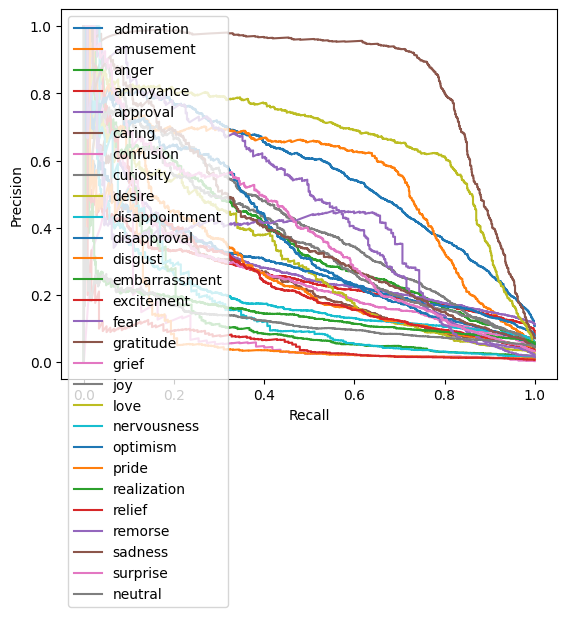

In [ ]:
# After training:
y_pred_binary = (y_pred > best_thresh).astype(int)  # Use tuned threshold

# 1. Classification report
print(classification_report(y_true, y_pred_binary, target_names=emotion_cols))

# 2. AUC scores
for i, emotion in enumerate(emotion_cols):
    print(f"{emotion}: AUC = {roc_auc_score(y_true[:, i], y_pred[:, i]):.4f}")

# 3. Plot precision-recall curves
for i, emotion in enumerate(emotion_cols):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    plt.plot(recall, precision, label=emotion)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

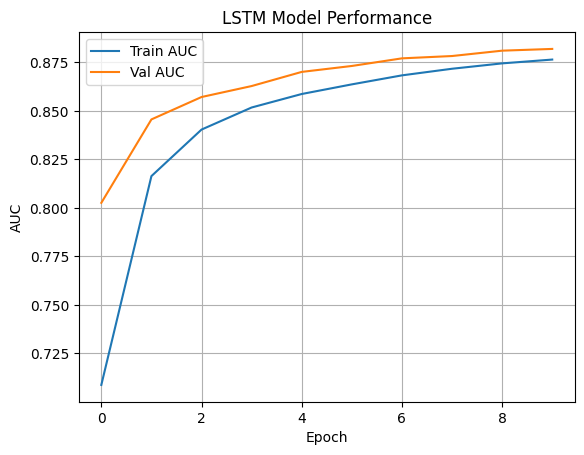

In [ ]:
plt.plot(history_emo.history['auc'], label='Train AUC')
plt.plot(history_emo.history['val_auc'], label='Val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('LSTM Model Performance')
plt.legend()
plt.grid(True)
plt.show()

The results show that the model performs quite well for frequently occurring emotions like admiration, amusement, and excitement, all with AUCs above 0.88. However, performance drops for rarer emotions such as grief, relief, and nervousness, with AUCs below 0.80. The training vs. validation AUC plot indicates a steady improvement and minimal overfitting, with the model generalizing well. These insights can guide future improvements, such as targeted data augmentation or class-specific weighting.

##### 2.2 CNN Model

2.2.1 Architecture

- 1. Embedding Layer: Use of a pre-trained (GloVe)

- 2. SpatialDropout1D: This forces the model to not rely on any one token too heavily, improving generalization.

- 3–5. Conv1D + MaxPooling Layers

- 6. GlobalMaxPooling1D: Helps reduce the dimensionality and highlights the most relevant features.

- 7. Dense + Dropout

- 8. Output Layer – Dense: A Dense layer with one neuron per emotion and sigmoid activation, enabling multi-label output.



In [ ]:
cnn_model = models.Sequential([
    embedding_layer,  # Assumes you already defined this (e.g., pretrained or trainable Embedding)

    # Spatial Dropout (to improve generalization over embeddings)
    layers.SpatialDropout1D(0.2),

    # 1D Convolutional Layers with multiple kernel sizes
    layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(128, kernel_size=4, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    layers.GlobalMaxPooling1D(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(len(emotion_cols), activation='sigmoid')  # Multi-label output
])


We now repeat what we did before

In [ ]:
cnn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)



In [ ]:
callbacks = [
    EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model_emo_cnn.h5', monitor='val_auc', save_best_only=True, mode='max')
]

history_emo = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks = callbacks,
    class_weight=class_weight_dict
)

Epoch 1/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - auc: 0.5180 - loss: 2.4969 - precision_2: 0.0433 - recall_2: 0.0219

500/500 ━━━━━━━━━━━━━━━━━━━━ 71s 134ms/step - auc: 0.5181 - loss: 2.4954 - precision_2: 0.0433 - recall_2: 0.0218 - val_auc: 0.7408 - val_loss: 0.1683 - val_precision_2: 0.9353 - val_recall_2: 0.0094
Epoch 2/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - auc: 0.6847 - loss: 1.8198 - precision_2: 0.7780 - recall_2: 0.0415

500/500 ━━━━━━━━━━━━━━━━━━━━ 78s 126ms/step - auc: 0.6848 - loss: 1.8195 - precision_2: 0.7779 - recall_2: 0.0415 - val_auc: 0.7965 - val_loss: 0.1523 - val_precision_2: 0.7502 - val_recall_2: 0.0854
Epoch 3/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - auc: 0.7525 - loss: 1.6858 - precision_2: 0.7472 - recall_2: 0.0734

500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - auc: 0.7525 - loss: 1.6857 - precision_2: 0.7472 - recall_2: 0.0734 - val_auc: 0.8102 - val_loss: 0.1487 - val_precision_2: 0.7357 - val_recall_2: 0.0897
Epoch 4/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - auc: 0.7781 - loss: 1.6236 - precision_2: 0.7237 - recall_2: 0.0822

500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 124ms/step - auc: 0.7781 - loss: 1.6236 - precision_2: 0.7237 - recall_2: 0.0823 - val_auc: 0.8174 - val_loss: 0.1467 - val_precision_2: 0.7418 - val_recall_2: 0.0907
Epoch 5/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - auc: 0.7926 - loss: 1.5803 - precision_2: 0.7105 - recall_2: 0.0918

500/500 ━━━━━━━━━━━━━━━━━━━━ 83s 126ms/step - auc: 0.7927 - loss: 1.5803 - precision_2: 0.7105 - recall_2: 0.0918 - val_auc: 0.8315 - val_loss: 0.1434 - val_precision_2: 0.7260 - val_recall_2: 0.0981
Epoch 6/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - auc: 0.8032 - loss: 1.5529 - precision_2: 0.7063 - recall_2: 0.1002

500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 125ms/step - auc: 0.8032 - loss: 1.5528 - precision_2: 0.7063 - recall_2: 0.1002 - val_auc: 0.8337 - val_loss: 0.1422 - val_precision_2: 0.7080 - val_recall_2: 0.1087
Epoch 7/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - auc: 0.8116 - loss: 1.5242 - precision_2: 0.7028 - recall_2: 0.1076

500/500 ━━━━━━━━━━━━━━━━━━━━ 62s 125ms/step - auc: 0.8116 - loss: 1.5241 - precision_2: 0.7028 - recall_2: 0.1076 - val_auc: 0.8417 - val_loss: 0.1401 - val_precision_2: 0.7139 - val_recall_2: 0.1202
Epoch 8/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - auc: 0.8175 - loss: 1.4995 - precision_2: 0.6955 - recall_2: 0.1168

500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 124ms/step - auc: 0.8175 - loss: 1.4994 - precision_2: 0.6955 - recall_2: 0.1168 - val_auc: 0.8425 - val_loss: 0.1406 - val_precision_2: 0.7102 - val_recall_2: 0.1221
Epoch 9/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - auc: 0.8221 - loss: 1.4807 - precision_2: 0.6908 - recall_2: 0.1227

500/500 ━━━━━━━━━━━━━━━━━━━━ 83s 126ms/step - auc: 0.8221 - loss: 1.4806 - precision_2: 0.6907 - recall_2: 0.1228 - val_auc: 0.8449 - val_loss: 0.1394 - val_precision_2: 0.6946 - val_recall_2: 0.1330
Epoch 10/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - auc: 0.8270 - loss: 1.4647 - precision_2: 0.6868 - recall_2: 0.1280

500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - auc: 0.8270 - loss: 1.4647 - precision_2: 0.6868 - recall_2: 0.1281 - val_auc: 0.8450 - val_loss: 0.1393 - val_precision_2: 0.6943 - val_recall_2: 0.1362


In [ ]:
best_model_emo_cnn = load_model(
    'best_model_emo_cnn.h5',
    compile=True
)

2.2.2 Performance Metrics

As previously done, we now proceed to predict on the test set and evaluate the model using multiple thresholds in order to identify the one that yields the highest F1-score.

In [ ]:
# Tokenize test data
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [ ]:
y_pred = best_model_emo_cnn.predict(X_test_seq_padded)  # Shape: (n_samples, 28)

500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [ ]:
thresholds = np.arange(0.1, 0.9, 0.05)
best_f1 = 0
best_thresh = 0.5

for thresh in thresholds:
    y_pred_binary = (y_pred > thresh).astype(int)
    f1 = f1_score(y_true, y_pred_binary, average='macro')
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Best threshold: {best_thresh:.2f}, F1-score: {best_f1:.4f}")

Best threshold: 0.15, F1-score: 0.3044


Again, we evaluate the CNN model's performance on the test set by calculating precision, recall, and F1-score for each emotion, along with macro, micro, and weighted averages. As before, we also compute AUC scores per class to assess the model's ability to distinguish between positive and negative instances for each emotion. Finally, we plot the training and validation AUC over epochs to monitor learning behavior.

500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

    admiration       0.54      0.48      0.51      1721
     amusement       0.57      0.64      0.61       928
         anger       0.28      0.50      0.36       838
     annoyance       0.28      0.29      0.28      1339
      approval       0.00      0.00      0.00      1803
        caring       0.25      0.32      0.28       590
     confusion       0.21      0.38      0.27       743
     curiosity       0.37      0.47      0.41       961
        desire       0.21      0.48      0.30       373
disappointment       0.12      0.00      0.00       882
   disapproval       0.28      0.21      0.24      1141
       disgust       0.22      0.37      0.28       521
 embarrassment       0.15      0.27      0.19       226
    excitement       0.23      0.33      0.27       566
          fear       0.34      0.56      0.42       341
     gratitude       0.85      0.76      0.80      1144
         grief       0.08      0.38      0.13  

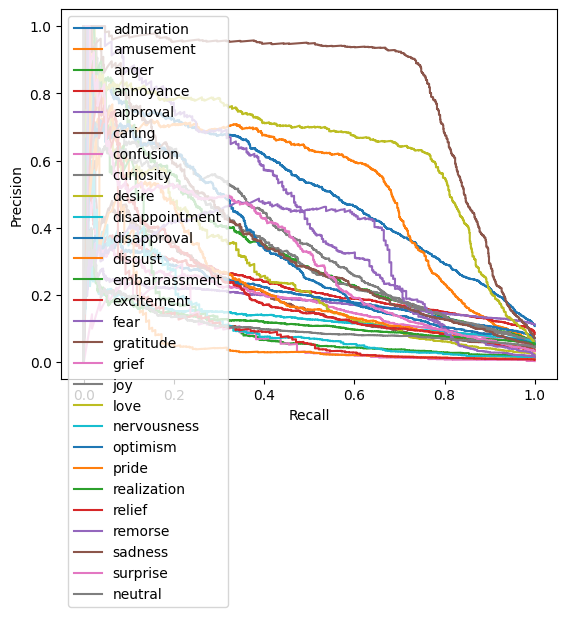

In [ ]:
# After training:
y_pred = best_model_emo_cnn.predict(X_test_seq_padded)
y_pred_binary = (y_pred > best_thresh).astype(int)  # Use tuned threshold

# 1. Classification report
print(classification_report(y_true, y_pred_binary, target_names=emotion_cols))

# 2. AUC scores
for i, emotion in enumerate(emotion_cols):
    print(f"{emotion}: AUC = {roc_auc_score(y_true[:, i], y_pred[:, i]):.4f}")

# 3. Plot precision-recall curves
for i, emotion in enumerate(emotion_cols):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    plt.plot(recall, precision, label=emotion)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

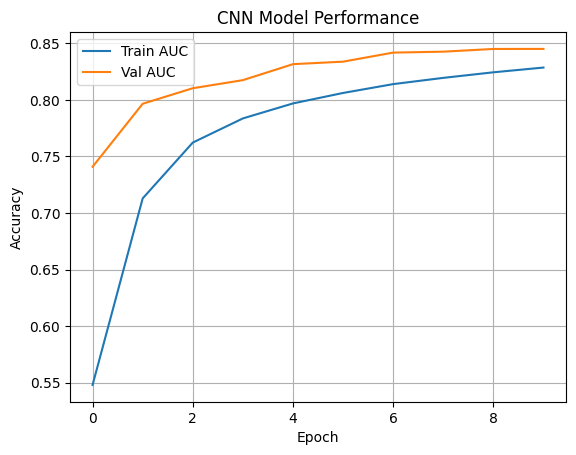

In [ ]:
plt.plot(history_emo.history['auc'], label='Train AUC')
plt.plot(history_emo.history['val_auc'], label='Val AUC')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Model Performance')
plt.legend()
plt.grid(True)
plt.show()

Overall, the CNN model demonstrates strong performance on more frequent emotions like admiration, amusement, and curiosity, with AUCs consistently above 0.86. However, the model continues to struggle with less frequent classes such as relief, grief, and disgust, highlighting ongoing challenges with class imbalance. Compared to the LSTM-based model, the CNN achieves slightly lower recall and F1 on rarer classes but converges quickly and maintains good generalization, as indicated by the stable validation AUC curve.

##Final Decision

For the sentiment task, we chose the LSTM model because it showed the best performance in terms of accuracy and generalization. It had strong results on the validation set without signs of overfitting. For emotion classification, we also selected the LSTM model, as it performed better than the CNN models, especially on difficult and less frequent emotions.

## Multi-Task Learning (MLT)

It is now time to combine the two chosen models into a single unified architecture that can handle both tasks—sentiment and emotion classification—simultaneously. By aggregating them into one model with a shared base and two output heads, we aim to take advantage of shared representations while producing separate predictions for each task. This setup allows for more efficient training and the potential for improved performance through multi-task learning.

We start by setting up the new variables. For max_sequence_length, we chose the highest value used in the previous models to ensure compatibility with both tasks. Regarding the batch_size, we had to select a relatively large value to avoid memory issues—smaller batch sizes caused the model to crash due to computational limitations. These adjustments ensure the unified model can train effectively within available hardware constraints.

In [ ]:
max_sequence_length = 400
batch_size = 256

After this, we set up a new embedding layer to serve as the shared input for both tasks. This layer will help capture the underlying structure of the text and provide a consistent representation for the combined model.

In [ ]:
embedding_layer = Embedding(input_dim=33039,  # or vocab_size for emotions
                            output_dim=100,
                            input_length=max_sequence_length,
                            trainable=True)  # or False if using fixed GloVe

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


We now move on to the creation of the multi-task architecture. This model consists of a shared embedding layer, followed by two independent branches: one for emotion classification and the other for sentiment prediction. Both branches process the same embedded input but use different LSTM and dense layer stacks tailored to the nature of each task. This setup allows the model to leverage shared text representations while still learning task-specific features, ultimately optimizing both objectives in parallel.

In [ ]:
# Define input layer
input_layer = Input(shape=(max_sequence_length,), name='input_text')

# Shared embedding layer only
shared_embedding = embedding_layer(input_layer)

# --- Emotion Branch (completely independent) ---
x_emotion = layers.SpatialDropout1D(0.3)(shared_embedding)
x_emotion = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x_emotion)
x_emotion = layers.LayerNormalization()(x_emotion)
x_emotion = layers.GlobalMaxPooling1D()(x_emotion)
x_emotion = layers.LayerNormalization()(x_emotion)
x_emotion = layers.Dense(128, activation='relu')(x_emotion)
x_emotion = layers.Dense(64, activation='relu')(x_emotion)
emotion_output = layers.Dense(len(emotion_cols), activation='sigmoid', name='emotion')(x_emotion)

# --- Sentiment Branch (completely independent) ---
x_sentiment = layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(shared_embedding)
x_sentiment = layers.Dropout(0.3)(x_sentiment)
x_sentiment = layers.Dense(64, activation='relu')(x_sentiment)
x_sentiment = layers.Dropout(0.3)(x_sentiment)
sentiment_output = layers.Dense(1, activation='sigmoid', name='sentiment')(x_sentiment)

# Model with independent outputs
mtl_model = models.Model(
    inputs=input_layer,
    outputs=[sentiment_output, emotion_output],
    name='multi_task_lstm_independent'
)

To handle the complexity of multi-label classification and missing labels, we define custom loss functions that extend standard loss behavior.

In [ ]:
def masked_binary_crossentropy(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    #y_pred = safe_sigmoid(y_pred)

    # Calculate per-element loss
    per_element_loss = tf.keras.backend.binary_crossentropy(y_true, y_pred)

    # Mask and sum losses per sample, then divide by valid counts
    masked_loss = per_element_loss * mask
    valid_counts = tf.reduce_sum(mask, axis=1) + 1e-7
    per_sample_loss = tf.reduce_sum(masked_loss, axis=1) / valid_counts

    return per_sample_loss  # Shape: (batch_size,)

def masked_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
        #y_pred = safe_sigmoid(y_pred)
        p_t = y_true * y_pred + (1-y_true)*(1-y_pred)
        alpha_factor = y_true*alpha + (1-y_true)*(1-alpha)
        modulating_factor = tf.pow(1-p_t, gamma)
        ce_loss = -tf.math.log(tf.maximum(p_t, 1e-7))
        per_element_loss = alpha_factor * modulating_factor * ce_loss
        masked_loss = per_element_loss * mask
        valid_counts = tf.reduce_sum(mask, axis=1) + 1e-7
        return tf.reduce_sum(masked_loss, axis=1) / valid_counts  # Shape: (batch_size,)
    return loss

def masked_focal_loss_with_weights(gamma=2.0, alpha=0.25, class_weights=None):
    def loss(y_true, y_pred):
        mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        ce_loss = -tf.math.log(tf.maximum(p_t, 1e-7))

        if class_weights is not None:
            weights = tf.constant(class_weights, dtype=tf.float32)
            weight_tensor = tf.reduce_sum(y_true * weights, axis=-1, keepdims=True)
            ce_loss *= weight_tensor

        loss_tensor = alpha_factor * modulating_factor * ce_loss
        masked_loss = loss_tensor * mask
        valid_counts = tf.reduce_sum(mask, axis=1) + 1e-7
        return tf.reduce_sum(masked_loss, axis=1) / valid_counts
    return loss




With the model architecture and loss functions defined, we now move on to processing the data to fit the unified format required by our multi-task model. This includes preparing the input sequences, padding them consistently, and organizing the sentiment and emotion labels into a structure that supports simultaneous training of both tasks.

In [ ]:
# Initialize empty lists
X_text_train = []
y_sentiment_train = []

# Loop through the dataset and collect values
for text_batch, label_batch in train_ds_vec:
    X_text_train.extend(text_batch.numpy())
    y_sentiment_train.extend(label_batch.numpy())

X_text_train = np.array(X_text_train)
y_sentiment_train = np.array(y_sentiment_train)

In [ ]:
# Initialize empty lists
X_text_val = []
y_sentiment_val = []

# Loop through the dataset and collect values
for text_batch, label_batch in val_ds_vec:
    X_text_val.extend(text_batch.numpy())
    y_sentiment_val.extend(label_batch.numpy())

X_text_val = np.array(X_text_val)
y_sentiment_val = np.array(y_sentiment_val)

In [ ]:
# Initialize empty lists
X_text_train_e = []
y_emotion_train_e = []

# Loop through the dataset and collect values
for text_batch, label_batch in train_ds:
    X_text_train_e.extend(text_batch.numpy())
    y_emotion_train_e.extend(label_batch.numpy())

X_text_train_e = np.array(X_text_train_e)
y_emotion_train_e = np.array(y_emotion_train_e)

In [ ]:
# Initialize empty lists
X_text_val_e = []
y_emotion_val_e = []

# Loop through the dataset and collect values
for text_batch, label_batch in val_ds:
    X_text_val_e.extend(text_batch.numpy())
    y_emotion_val_e.extend(label_batch.numpy())

X_text_val_e = np.array(X_text_val_e)
y_emotion_val_e = np.array(y_emotion_val_e)

# Ensure all inputs have same length
X_text_train_e = pad_sequences(X_text_train_e, maxlen=max_sequence_length, padding='post', truncating='post')
X_text_val_e = pad_sequences(X_text_val_e, maxlen=max_sequence_length, padding='post', truncating='post')

In [ ]:
X_text_all = np.concatenate([X_text_train, X_text_train_e])
y_sentiment_all = np.concatenate([y_sentiment_train, np.full((len(y_emotion_train_e),), -1)])
y_emotion_all = np.concatenate([np.full((len(y_sentiment_train), 28), -1), y_emotion_train_e])

We compute class weights to handle imbalance in the emotion labels.

In [ ]:
# Replace -1 with 0 for counting (so missing labels don't count)
label_matrix = np.where(y_emotion_all == -1, 0, y_emotion_all)

# Sum across samples → total per class
class_counts = label_matrix.sum(axis=0)

# Create synthetic label vector (e.g., [0, 0, 1, 2, 2, 2, ...])
flat_labels = []
for i, count in enumerate(class_counts):
    flat_labels.extend([i] * int(count))

# Now compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(emotion_cols)),
    y=flat_labels
)
class_weights = np.array(class_weights)

In [ ]:
# Combine validation text data
X_text_val_combined = np.concatenate([X_text_val, X_text_val_e])

# Create masked sentiment validation labels
y_sentiment_val_combined = np.concatenate([
    y_sentiment_val,
    np.full((len(y_emotion_val_e),), -1)  # mask for emotion-only samples
])

# Create masked emotion validation labels
y_emotion_val_combined = np.concatenate([
    np.full((len(y_sentiment_val), 28), -1),  # mask for sentiment-only samples
    y_emotion_val_e
])


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_text_all, {'sentiment': y_sentiment_all, 'emotion': y_emotion_all})
)
# 💡 Use a large shuffle buffer to truly mix sentiment/emotion
train_ds = train_ds.shuffle(buffer_size=len(X_text_all), seed=42, reshuffle_each_iteration=False)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (X_text_val_combined, {'sentiment': y_sentiment_val_combined, 'emotion': y_emotion_val_combined})
)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


We now trained the model using our custom masked_loss function, which accounts for the fact that each training example contains labels for either sentiment or emotion — not both. This ensures that only the corresponding branch's loss is updated during training.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

mtl_model.compile(
    optimizer=optimizer,
    loss={
        'sentiment': masked_binary_crossentropy,
        'emotion': masked_focal_loss_with_weights(class_weights=class_weights)
    },
    metrics={
        'sentiment': 'accuracy',
        'emotion': [tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()]
    })

In [ ]:
history_joint = mtl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss', patience=0),
               ModelCheckpoint('best_final_model.h5', monitor='val_loss', save_best_only=True, mode='min')]
)


Epoch 1/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - emotion_auc: 0.5597 - emotion_loss: 0.0203 - emotion_precision: 0.1935 - emotion_recall: 0.0192 - loss: 0.5350 - sentiment_accuracy: 0.0842 - sentiment_loss: 0.0858

578/578 ━━━━━━━━━━━━━━━━━━━━ 4101s 7s/step - emotion_auc: 0.5597 - emotion_loss: 0.0203 - emotion_precision: 0.1935 - emotion_recall: 0.0191 - loss: 0.5348 - sentiment_accuracy: 0.0842 - sentiment_loss: 0.0858 - val_emotion_auc: 0.6330 - val_emotion_loss: 0.0126 - val_emotion_precision: 0.0000e+00 - val_emotion_recall: 0.0000e+00 - val_loss: 0.5870 - val_sentiment_accuracy: 0.1990 - val_sentiment_loss: 0.0956
Epoch 2/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 4032s 7s/step - emotion_auc: 0.6363 - emotion_loss: 0.0141 - emotion_precision: 0.9071 - emotion_recall: 0.0028 - loss: 0.3348 - sentiment_accuracy: 0.1144 - sentiment_loss: 0.0534 - val_emotion_auc: 0.5163 - val_emotion_loss: 0.0118 - val_emotion_precision: 0.9703 - val_emotion_recall: 0.0180 - val_loss: 0.6440 - val_sentiment_accuracy: 0.1970 - val_sentiment_loss: 0.1053


In [ ]:
custom_objects = {
    'masked_binary_crossentropy': masked_binary_crossentropy,
    'masked_focal_loss_with_weights': masked_focal_loss_with_weights(class_weights=class_weights)
}

model= load_model('best_final_model.h5', custom_objects=custom_objects)

model.compile(
    optimizer='adam',
    loss={
        'sentiment': masked_binary_crossentropy,
        'emotion': masked_focal_loss_with_weights(class_weights=class_weights)
    },
    metrics={
        'sentiment': 'accuracy',
        'emotion': [tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()]
    })

To evaluate the performance of the combined model, we began by preparing the test set.

In [ ]:
emotion_labels = ["admiration", "amusement", "anger", "annoyance", "approval", "caring",
                  "confusion", "curiosity", "desire", "disappointment", "disapproval",
                  "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
                  "joy", "love", "nervousness", "optimism", "pride", "realization", "relief",
                  "remorse", "sadness", "surprise", "neutral"]

In [ ]:
# Inicializar listas
X_text_test = []
y_sentiment_test = []

# Extrair os batches de test_ds
for text_batch, label_batch in test_ds_vec:
    for t in text_batch:
        X_text_test.append(t.numpy())
    for l in label_batch:
        y_sentiment_test.append(l.numpy())

X_text_test = np.array(X_text_test)
y_sentiment_test = np.array(y_sentiment_test)

NameError: name 'test_ds_vec' is not defined

In [ ]:
# Inicializar listas
X_text_test_e = []
y_emotion_test_e = []

# Extrair os batches de test_ds
for text_batch, label_batch in test_ds:
    for t in text_batch:
        X_text_test_e.append(t.numpy().decode("utf-8"))
    for l in label_batch:
        y_emotion_test_e.append(l.numpy())

# Agora aplica tokenizer normalmente
X_text_test_e_seq = tokenizer.texts_to_sequences(X_text_test_e)
X_text_test_e = pad_sequences(X_text_test_e_seq, maxlen=max_sequence_length, padding='post', truncating='post')

# Garante que cada elemento seja uma lista (mesmo que com uma única label)
y_emotion_test_e = [[label] for label in y_emotion_test_e]

# Agora aplica a binarização
mlb = MultiLabelBinarizer(classes=emotion_labels)
y_emotion_test_e = mlb.fit_transform(y_emotion_test_e)

In [ ]:
X_text_all_test = np.concatenate([X_text_test, X_text_test_e])
y_sentiment_all_test = np.concatenate([y_sentiment_test, np.full((len(y_emotion_test_e),), -1)])
y_emotion_all_test = np.concatenate([np.full((len(y_sentiment_test), 28), -1), y_emotion_test_e])

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices(
    (X_text_all_test, {'sentiment': y_sentiment_all_test, 'emotion': y_emotion_all_test})
)
# 💡 Use a large shuffle buffer to truly mix sentiment/emotion
test_ds = test_ds.shuffle(buffer_size=len(X_text_all_test), seed=42, reshuffle_each_iteration=True)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

To evaluate the effectiveness of our multi-task model, we now assess its performance on the test set. Since the model produces two distinct outputs—one for sentiment and one for emotion—we begin by running predictions on the test data and then separate the results accordingly.

In [ ]:
results = model.evaluate(test_ds)

In [ ]:
y_pred = model.predict(test_ds)

In [ ]:
sentiment_preds, emotion_preds = model.predict(test_ds)

In [ ]:
n_sentiment = len(y_sentiment_test)

sentiment_preds_only = sentiment_preds[:n_sentiment]
emotion_preds_only = emotion_preds[n_sentiment:]

In [ ]:
# Arredonda as previsões para 0 ou 1
y_pred_sentiment = (sentiment_preds_only > 0.5).astype(int)

print("Sentiment Evaluation:\n")
print(classification_report(y_sentiment_test, y_pred_sentiment, target_names=["negative", "positive"]))

In [ ]:
# Binariza previsões
y_pred_emotion_bin = (emotion_preds_only > 0.5).astype(int)

# F1-score macro
print("Emotion F1-score (macro):", f1_score(y_emotion_test_e, y_pred_emotion_bin, average='macro'))

# Relatório completo
print("Emotion Evaluation:\n")
print(classification_report(y_emotion_test_e, y_pred_emotion_bin, target_names=emotion_labels))

A set just to test the performance of the model in absolute new data

In [ ]:
test_reviews = [
    {"text": "This movie was absolutely stunning. I loved every second.",
     "sentiment": "positive", "emotions": ["joy", "admiration"]},

    {"text": "I'm so disappointed with this purchase. It broke after one use.",
     "sentiment": "negative", "emotions": ["disappointment", "anger"]},

    {"text": "The interface is clean and the app works well.",
     "sentiment": "positive", "emotions": ["approval", "satisfaction"]},

    {"text": "I feel so sad after reading that book.",
     "sentiment": "negative", "emotions": ["sadness"]},

    {"text": "What a pleasant surprise! This exceeded my expectations.",
     "sentiment": "positive", "emotions": ["surprise", "gratitude"]},

    {"text": "The experience was average. Nothing particularly good or bad.",
     "sentiment": "neutral", "emotions": ["neutral"]},

    {"text": "I can't stop laughing, that was hilarious!",
     "sentiment": "positive", "emotions": ["amusement"]},

    {"text": "They didn't even bother responding to my issue.",
     "sentiment": "negative", "emotions": ["annoyance", "anger"]},

    {"text": "Wow, this really makes you think. Very deep.",
     "sentiment": "positive", "emotions": ["curiosity", "admiration"]},

    {"text": "It’s fine. Does the job, nothing more.",
     "sentiment": "neutral", "emotions": ["neutral"]},

    {"text": "The customer service team was rude and unhelpful.",
     "sentiment": "negative", "emotions": ["disapproval", "anger"]},

    {"text": "I’m so proud of what we accomplished.",
     "sentiment": "positive", "emotions": ["pride", "gratitude"]},

    {"text": "This feels like a scam. I'm really angry.",
     "sentiment": "negative", "emotions": ["anger", "disgust"]},

    {"text": "The product is okay, but shipping took forever.",
     "sentiment": "neutral", "emotions": ["annoyance"]},

    {"text": "Beautifully designed and very intuitive.",
     "sentiment": "positive", "emotions": ["admiration", "satisfaction"]},

    {"text": "Ugh, I can't believe I paid money for this.",
     "sentiment": "negative", "emotions": ["regret", "anger"]},

    {"text": "Super excited to start using this tool!",
     "sentiment": "positive", "emotions": ["excitement"]},

    {"text": "Meh. Not terrible, but not great either.",
     "sentiment": "neutral", "emotions": ["neutral"]},

    {"text": "This changed my life. I'm so grateful.",
     "sentiment": "positive", "emotions": ["gratitude", "joy"]},

    {"text": "How frustrating! It just won’t load.",
     "sentiment": "negative", "emotions": ["frustration", "annoyance"]},

    {"text": "I’m intrigued by this new concept.",
     "sentiment": "positive", "emotions": ["curiosity"]},

    {"text": "The update made things worse, not better.",
     "sentiment": "negative", "emotions": ["disapproval", "disappointment"]},

    {"text": "Such a calming and peaceful experience.",
     "sentiment": "positive", "emotions": ["contentment", "relief"]},

    {"text": "It’s hard to describe, but I feel very conflicted.",
     "sentiment": "neutral", "emotions": ["confusion", "neutral"]},

    {"text": "Seriously impressed with the results.",
     "sentiment": "positive", "emotions": ["admiration", "surprise"]},
]



In [ ]:
texts = [item["text"] for item in test_reviews]
true_sentiments = [item["sentiment"] for item in test_reviews]
true_emotions = [item["emotions"] for item in test_reviews]

text_sequences = tokenizer.texts_to_sequences(texts)
text_padded = pad_sequences(text_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

sentiment_preds, emotion_preds = mtl_model.predict(text_padded)

pred_sentiments = ['positive' if p[0] >= 0.5 else 'negative' for p in sentiment_preds]
top_emotions = [emotion_cols[np.argmax(p)] for p in emotion_preds]

for i in range(len(texts)):
    print(f"\n📝 Text: {texts[i]}")
    print(f"✅ True Sentiment: {true_sentiments[i]}")
    print(f"🤖 Predicted Sentiment: {pred_sentiments[i]}")
    print(f"✅ True Emotions: {true_emotions[i]}")
    print(f"🤖 Top Predicted Emotion: {top_emotions[i]}")


In [ ]:
for emotion, score in zip(emotion_cols, emotion_scores):
    print(f"{emotion}: {score:.3f}")
